In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np

In [17]:
# conexion con la base de datos
db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='matematicas12345',
    database='ecommerce'
)
cursor = db.cursor()

# 1. List all unique cities where customers are located.

In [19]:
query = """ select distinct customer_city from customers """
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data)
df.head()


,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [113]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp)=2017 """
cursor.execute(query)
data = cursor.fetchall()
"ordenes totales ejecutadas en el año 2017 fueron",data[0][0]

('ordenes totales ejecutadas en el año 2017 fueron', 45101)

# 3. Find the total sales per category.

In [103]:
query = """ select upper (products.product_category) categoria, format (sum(payments.payment_value),2) venta
            from products
            join order_items on products.product_id = order_items.product_id
            join payments
            on payments.order_id = order_items.order_id
            group by categoria
            """
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["Categoria","Ventas totales"])
df

,Categoria,Ventas totales
0,PERFUMERY,"506,738.66"
1,FURNITURE DECORATION,"1,430,176.39"
2,TELEPHONY,"486,882.05"
3,BED TABLE BATH,"1,712,553.67"
4,AUTOMOTIVE,"852,294.33"
...,...,...
69,CDS MUSIC DVDS,"1,199.43"
70,LA CUISINE,"2,913.53"
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,"2,174.43"


# 4. Calculate the percentage of orders that were paid in installments.

In [79]:
query = """ SELECT 
                (SUM(CASE WHEN payment_installments > 1 THEN 1 ELSE 0 END) * 100.0) / COUNT(*) AS porcentaje_pagos_a_cuotas
            FROM payments
 """
cursor.execute(query)
data = cursor.fetchall()
"el porcentaje de ordenes que fueron pagadas a cuotas es",data[0][0]

('el porcentaje de ordenes que fueron pagadas a cuotas es',
 Decimal('49.41763'))

# 5. Count the number of customers from each state.

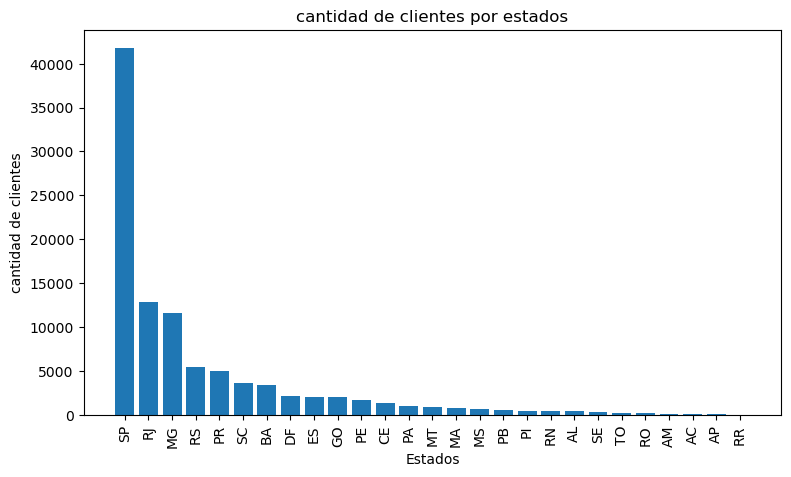

In [151]:
query = """ select customer_state, count(customer_id)
            from customers
            group by customer_state
            """
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["Estado","Cantidad_cliente"])
df = df.sort_values(by = "Cantidad_cliente", ascending=False)
plt.figure(figsize = (9,5))
plt.bar(df["Estado"],df["Cantidad_cliente"])
plt.xticks(rotation = 90)
plt.xlabel("Estados")
plt.ylabel("cantidad de clientes")
plt.title("cantidad de clientes por estados")
plt.show()


# 6. Calculate the number of orders per month in 2018.

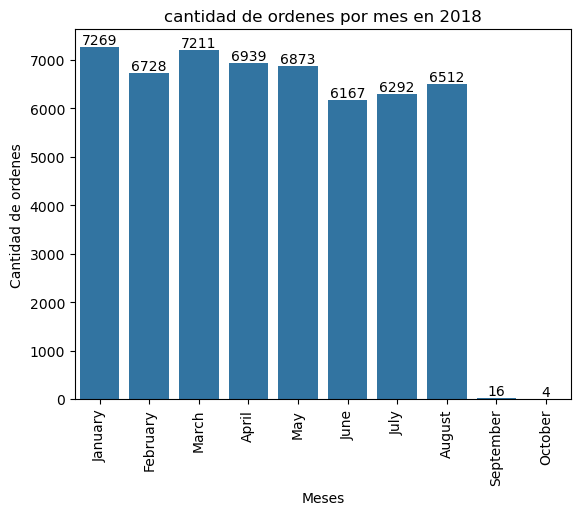

In [153]:
query = """ SELECT 
                MONTHNAME(STR_TO_DATE(order_purchase_timestamp, '%Y-%m-%d %H:%i:%s')) AS meses, 
                COUNT(order_id) AS cantidad_de_ordenes
            FROM orders 
            WHERE YEAR(STR_TO_DATE(order_purchase_timestamp, '%Y-%m-%d %H:%i:%s')) = 2018
            GROUP BY MONTHNAME(STR_TO_DATE(order_purchase_timestamp, '%Y-%m-%d %H:%i:%s'));
 """
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["Meses","Cantidad de ordenes"])
months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October"
]
ax = sns.barplot(x = df["Meses"],y = df["Cantidad de ordenes"], data = df, order = months)
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.title("cantidad de ordenes por mes en 2018")
plt.show()

# 7. Find the average number of products per order, grouped by customer city.

In [165]:
query = """ with cantidad_por_orden as
(select orders.order_id, orders.customer_id,round(count(order_items.order_id)) as cantidad_articulos
from orders 
join order_items on order_items.order_id = orders.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round (avg(cantidad_por_orden.cantidad_articulos),2) as promedio_producto_por_orden
from customers
join cantidad_por_orden on customers.customer_id = cantidad_por_orden.customer_id
group by customers.customer_city order by promedio_producto_por_orden desc
 """
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["city","promedio_producto_por_orden"])
df

,city,promedio_producto_por_orden
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
...,...,...
4105,lagoa da canoa,1.00
4106,japaratuba,1.00
4107,sebastiao leal,1.00
4108,morro agudo de goias,1.00


# 8. Calculate the percentage of total revenue contributed by each product category.

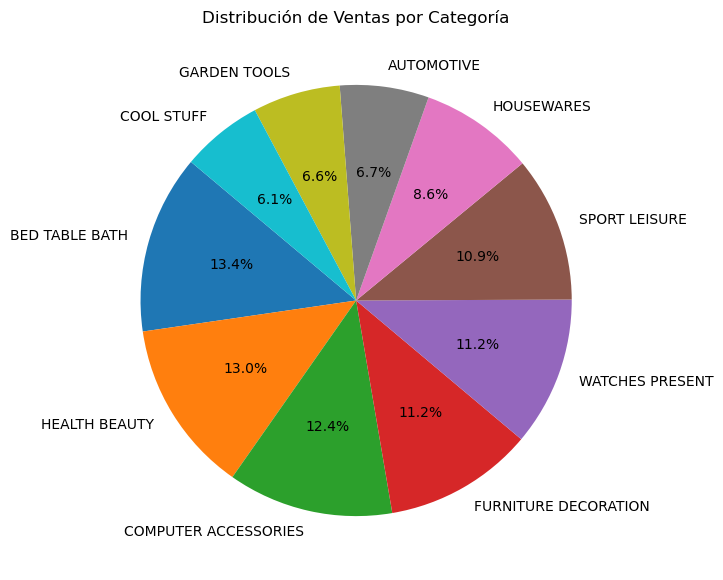

In [37]:
query = """ select upper (products.product_category) categoria, round ((sum(payments.payment_value)/ (select sum(payment_value)from payments))*100,2) venta_porcentaje
from products
join order_items on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by categoria order by venta_porcentaje desc;
            """
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["Categoria","Ventas porcentaje"])
top_n = 10  # Número de categorías principales a mostrar
df = df.sort_values(by="Ventas porcentaje", ascending=False)
top_df = df.head(top_n)
plt.figure(figsize=(10, 7))
plt.pie(top_df["Ventas porcentaje"], labels=top_df["Categoria"], autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Ventas por Categoría')
plt.show()


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [53]:
query = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns=["Categoria","Cantidad de producto vendidos","promedio de precio de productos"])
df
arr1 = df["Cantidad de producto vendidos"]
arr2 = df["promedio de precio de productos"]
a = np.corrcoef([arr1,arr2])
print(a)
print("Correlación Negativa: El valor negativo (-0.106) indica que hay una ligera tendencia a que a mayor precio promedio, menor cantidad de productos vendidos.")


[[ 1.         -0.10631514]
 [-0.10631514  1.        ]]
Correlación Negativa: El valor negativo (-0.106) indica que hay una ligera tendencia a que a mayor precio promedio, menor cantidad de productos vendidos.


# 10 Calculate the total revenue generated by each seller, and rank them by revenue.

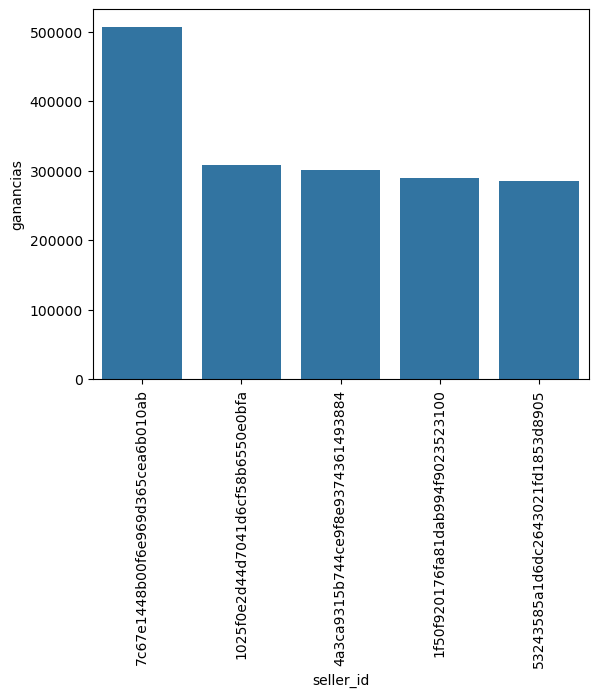

In [73]:
query = """SELECT *, 
                  DENSE_RANK() OVER (ORDER BY ganancias DESC) AS rn 
           FROM (
               SELECT order_items.seller_id, 
                      SUM(payments.payment_value) AS ganancias 
               FROM order_items 
               JOIN payments ON order_items.order_id = payments.order_id 
               GROUP BY order_items.seller_id
           ) AS subquery"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns=["seller_id","ganancias","rank"])
df = df.head()
sns.barplot(x ="seller_id", y= "ganancias", data = df)
plt.xticks(rotation=90)
plt.show()

# 11. Calculate the moving average of order values for each customer over their order history.

In [77]:
query = """select customer_id, order_purchase_timestamp,payment, avg(payment) over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns=["customer_id","date","payment","mov_avg"])
df = df.head()
df

,customer_id,date,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


# 12. Calculate the cumulative sales per month for each year.

In [81]:
query = """select years,months,payment, sum(payment)
over(order by years,months) as cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
monthname(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value)) as payment from orders join payments
on orders.order_id = payments.order_id
group by years,months order by years,months) as a;
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns=["years","months","payment","cumulative_sale"])
df = df.head()
df

,years,months,payment,cumulative_sale
0,2016,December,20.0,20.0
1,2016,October,59090.0,59110.0
2,2016,September,252.0,59362.0
3,2017,April,417788.0,477150.0
4,2017,August,674396.0,1151546.0


# 13. Calculate the year-over-year growth rate of total sales.

In [99]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value)) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years,((payment - lag(payment,1) over(order by years)) / lag(payment,1) over(order by years))*100 as previus_year from a
"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns=["years","year % growth"])
df = df.head()
df

,years,year % growth
0,2016,NaN
1,2017,12112.774165
2,2018,20.000919
